# Chapter 3.6. MNIST on TensorFlow

Original code in Nikolenko book was made in **TensorFlow 1.x (TF1)**, but here I will convert examples to **TensorFlow 2.0 (TF2)**.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from models_classes import LogRegModel
from losses import cross_entropy_loss
from metrics import accuracy
from utils import (
    _fix_seeds,
    plot_metric_history,
    show_images
)

## 1. Load data and visualize some examples

- MNIST have 70k images (1 channel) with size of 28x28 (784 if flatten). 
- Samples have already splitted into train (60k images) and test (10k images). 
- Target classes in categorical view

In [2]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = mnist
X_train, X_test = X_train / 255.0, X_test / 255.0

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


### Visualization:

Visualization methods (`show_images`, `plot_metric_history`) located in `utils.py`

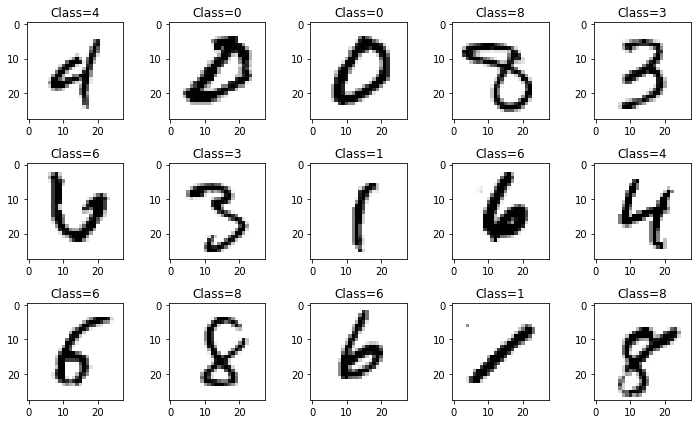

In [3]:
show_images(X_train, y_train, random_sample=True, seed=42, sample_size=15, num_cols=5)

## 2. Train and evaluate logistic regression using TF2

- Set constats
- Define train and evaluation process
- Initialize weigts
- Set model and optimier
- Loop over epochs (book way: "every epoch = one random batch" - leads to unstable results)
- Collect loss and metrics (accuracy) values
- Plot metrics history

In [4]:
# set constants
_fix_seeds(42)

batch_size = 128
num_steps = 2000
display_step = 100

# define train proces
def train(model, X, y, optimizer):
    """
    One step of train process
    
    params:
        model: model object to train
        X: data
        y: target 
        optimizer: tf optimizer
    return:
        loss_val: loss value
    """
    with tf.GradientTape() as t:
        y_pred = tf.nn.softmax(model(X))
        loss_val = cross_entropy_loss(y, y_pred)
        
    grads = t.gradient(loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    acc = accuracy(y, y_pred)
    
    return loss_val, acc

# define evaluate proces
def evaluate(model, X, y):
    """
    One step of evaluation process
    
    params:
        model: model object to evaluate
        X: data to evaluate
        y: target 
    return:
        loss_val: loss value
    """
    y_pred = tf.nn.softmax(model(X))
    loss_val = cross_entropy_loss(y, y_pred)
    
    acc = accuracy(y, y_pred)
    
    return loss_val, acc

In [5]:
# Initialize weigts 
W = tf.Variable(tf.random.normal([784, 10], dtype='float32'), name='weights')
b = tf.Variable(tf.zeros([10], dtype='float32'), name='biases')

# Set up model and optimier
model = LogRegModel(W, b)
optimizer = tf.optimizers.Adam(learning_rate=1e-2)

# collect metrics
loss_history = {
    'train': [],
    'test': []
}
acc_history = {
    'train': [],
    'test': []
}

# running optimization
for i in range(num_steps):
    
    # select train data batch
    indices = np.random.choice(len(X_train), batch_size)
    X_train_batch, y_train_batch = X_train[indices], y_train[indices]
    
    # Flatten data and make ohe over target
    X_train_batch_flat = tf.cast(X_train_batch.reshape(batch_size, 784), tf.float32)
    y_train_batch_ohe = tf.cast(tf.one_hot(y_train_batch, 10), tf.float32)
    
    # train model
    train_loss, train_acc = train(model, X_train_batch_flat, y_train_batch_ohe, optimizer)
    
    # select test data batch
    indices = np.random.choice(len(X_test), batch_size)
    X_test_batch, y_test_batch = X_test[indices], y_test[indices]
    
    # Flatten data and make ohe over target
    X_test_batch_flat = tf.cast(X_test_batch.reshape(batch_size, 784), tf.float32)
    y_test_batch_ohe = tf.cast(tf.one_hot(y_test_batch, 10), tf.float32)    
    
    # evaluate model
    test_loss, test_acc = evaluate(model, X_test_batch_flat, y_test_batch_ohe)
    
    # collect current metrics
    loss_history['train'].append(train_loss.numpy())
    loss_history['test'].append(test_loss.numpy())
    acc_history['train'].append(train_acc)
    acc_history['test'].append(test_acc)
    
    # output info
    if (i+1) % display_step == 0:
        print(f'Epoch {i+1}: train loss={train_loss.numpy()}, train acc={train_acc}')
        print(f'\t\ttest loss={test_loss.numpy()}, test acc={test_acc}\n')

Epoch 100: train loss=-0.42527493834495544, train acc=0.6171875
		test loss=-0.423614501953125, test acc=0.6015625

Epoch 200: train loss=-0.45459648966789246, train acc=0.6484375
		test loss=-0.4928797483444214, test acc=0.7109375

Epoch 300: train loss=-0.5159692764282227, train acc=0.7421875
		test loss=-0.4420052170753479, test acc=0.625

Epoch 400: train loss=-0.4747624397277832, train acc=0.6875
		test loss=-0.5087368488311768, test acc=0.734375

Epoch 500: train loss=-0.512468159198761, train acc=0.734375
		test loss=-0.5581157207489014, test acc=0.8046875

Epoch 600: train loss=-0.5431522130966187, train acc=0.78125
		test loss=-0.5191307067871094, test acc=0.75

Epoch 700: train loss=-0.5390471816062927, train acc=0.765625
		test loss=-0.4755876064300537, test acc=0.6875

Epoch 800: train loss=-0.5464346408843994, train acc=0.796875
		test loss=-0.5282319784164429, test acc=0.765625

Epoch 900: train loss=-0.5551012754440308, train acc=0.8046875
		test loss=-0.5277395248413086

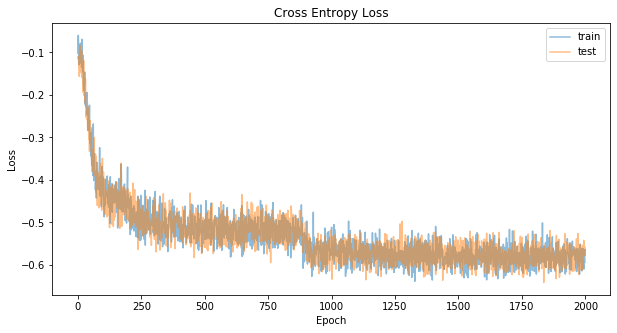

In [6]:
plot_metric_history(loss_history, title='Cross Entropy Loss')

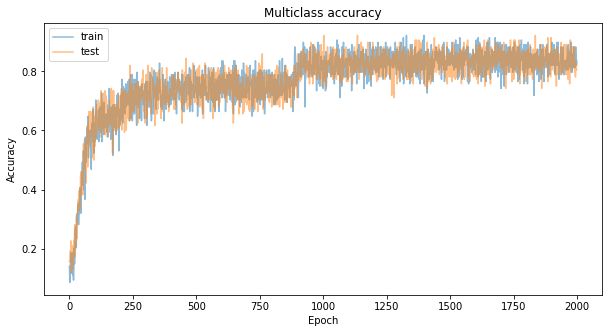

In [7]:
plot_metric_history(acc_history, title='Multiclass accuracy', ylabel='Accuracy')

## 3. Train and evaluate model with hidden layer using TF2

## 4. Train and evaluate model with hidden layer using TF2 with built-in loss method